In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [4]:
from importlib import import_module
python_code = import_module('python-synthpop')

ModuleNotFoundError: No module named 'python-synthpop'

### 1. Load data and prepare data

In [2]:
admissions_df = pd.read_csv('../datasets/data/bar_pass_prediction.csv', index_col=False)
print(admissions_df.shape)
print(admissions_df.columns)
print(admissions_df.isnull().sum())
display(admissions_df.head())

(22407, 39)
Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')
decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr             

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


In [3]:
# Remove all rows with missing values
admissions_df = admissions_df.dropna()
print(admissions_df.shape)
print(admissions_df.isnull().sum())

(20427, 39)
decile1b                   0
decile3                    0
ID                         0
decile1                    0
sex                        0
race                       0
cluster                    0
lsat                       0
ugpa                       0
zfygpa                     0
DOB_yr                     0
grad                       0
zgpa                       0
bar1                       0
bar1_yr                    0
bar2                       0
bar2_yr                    0
fulltime                   0
fam_inc                    0
age                        0
gender                     0
parttime                   0
male                       0
race1                      0
race2                      0
Dropout                    0
other                      0
asian                      0
black                      0
hisp                       0
pass_bar                   0
bar                        0
bar_passed                 0
tier                       0
in

**UI text**

A subset of the [Law School Admission Bar*](https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage) dataset is used as a demo. Synthetic data will be generated for the following columns: 

- sex: student gender, i.e. 1 (male), 2 (female)
- race1: race, i.e. asian, black, hispanic, white, other
- ugpa: The student's undergraduate GPA, continous variable;
- bar: Ground truth label indicating whether or not the student passed the bar, i.e. passed 1st time, passed 2nd time, failed, non-graduated

The CART method will be used  evaluate the distribution and correlation differences between the real and synthetic data.

*The original paper can be found [here](https://files.eric.ed.gov/fulltext/ED469370.pdf).

In [4]:
# demo dataset
original_data = admissions_df[['sex', 'race1', 'ugpa', 'bar']]
original_data.head()

,sex,race1,ugpa,bar
0,1.0,white,3.5,a Passed 1st time
1,1.0,white,3.5,a Passed 1st time
2,2.0,white,3.5,a Passed 1st time
3,2.0,white,3.5,a Passed 1st time
4,2.0,white,3.5,a Passed 1st time


#### 1.1 Data type detection

In [5]:
print(original_data.dtypes)

sex      float64
race1     object
ugpa     float64
bar       object
dtype: object


In [6]:
# automatically detect the data type of each column
dtypes_dict = original_data.dtypes.to_dict()
dtypes_dict

{'sex': dtype('float64'),
 'race1': dtype('O'),
 'ugpa': dtype('float64'),
 'bar': dtype('O')}

In [7]:
# replace 'float64' with 'float' and 'O' with 'object'
dtypes_dict = {k: 'float' if v == 'float64' else 'category' if v == 'O' else v for k, v in dtypes_dict.items()}
dtypes_dict

## UI text
print('Per column in the uploaded data, the following data types were detected:')
for key, value in dtypes_dict.items():
    print(f'{key}: {value}')

Per column in the uploaded data, the following data types were detected:
sex: float
race1: category
ugpa: float
bar: category


In [8]:
# Encode string columns to numeric values
label_encoders = {}
real_data = original_data.copy()
for column in original_data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    real_data[column] = label_encoders[column].fit_transform(original_data[column])

real_data.head()

,sex,race1,ugpa,bar
0,1.0,4,3.5,0
1,1.0,4,3.5,0
2,2.0,4,3.5,0
3,2.0,4,3.5,0
4,2.0,4,3.5,0


#### 1.2 Explanatory data analysis

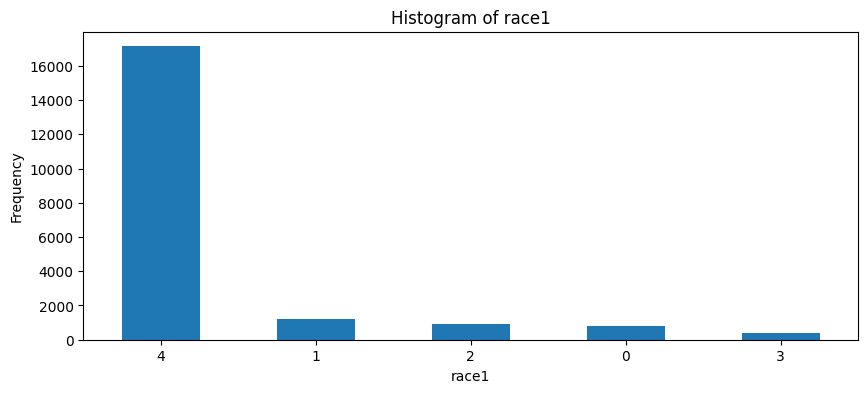

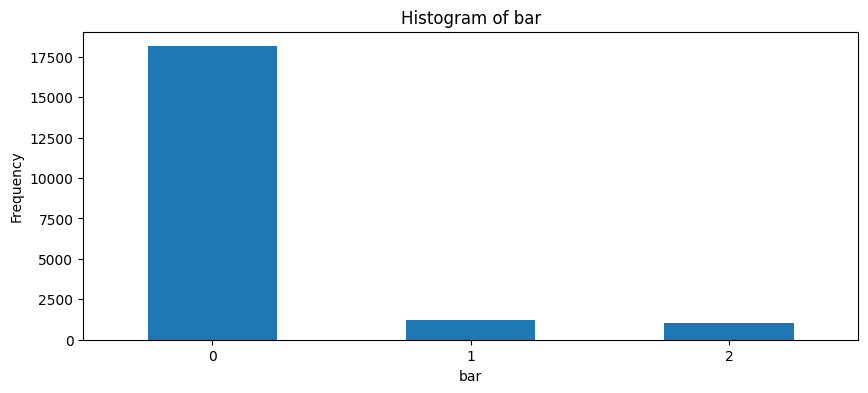

In [9]:
# EDA: plot histograms of categorical variables
for column in original_data.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 4))
    real_data[column].value_counts().plot(kind='bar')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.xticks(rotation=0)
    plt.ylabel('Frequency')
    plt.show()

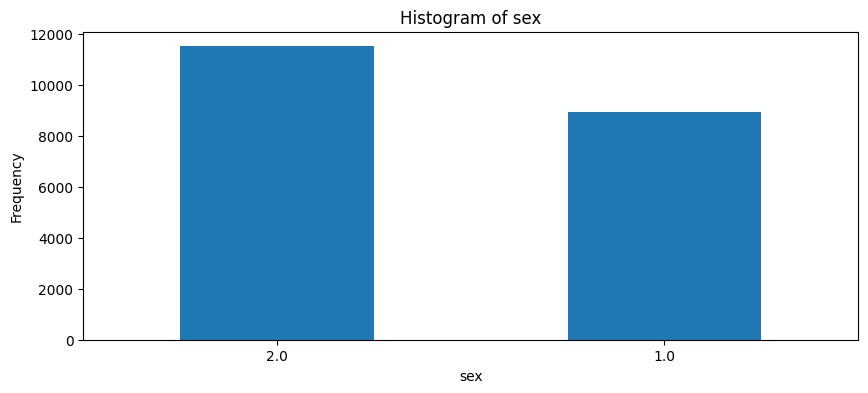

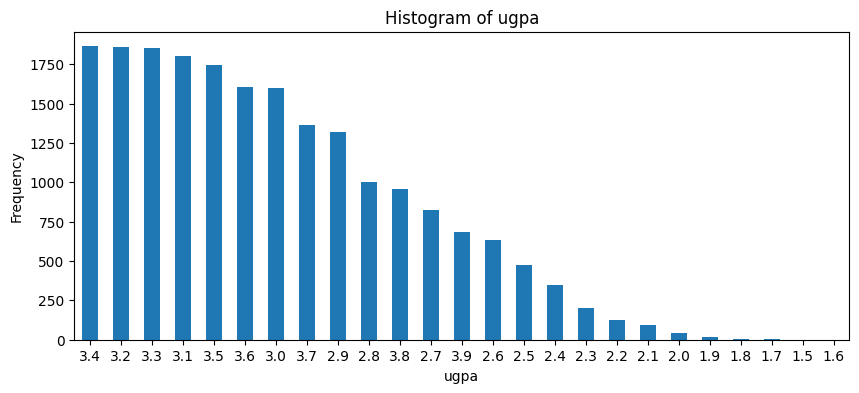

In [10]:
# EDA: plot histograms of numerical variables
for column in original_data.select_dtypes(exclude=['object']).columns:
    plt.figure(figsize=(10, 4))
    real_data[column].value_counts().plot(kind='bar')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.xticks(rotation=0)
    plt.ylabel('Frequency')
    plt.show()

Text(0.5, 1.0, 'Correlation matrix of original data')

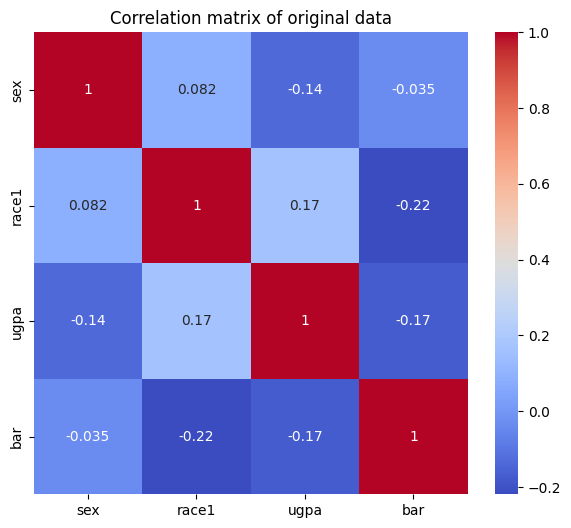

In [11]:
plt.figure(figsize=(7, 6))
sns.heatmap(real_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix of original data')

### 2. Synthetic data generation: Gaussian Copula

**UI text**

Gaussian copula (GC) is a statitical method to generata synthetic data that mimic the structure and relationships (dependencies) seen in real data. It works well when the data has relationships between variables that need to be preserved, even if the exact data values change. A 'copula' helps describe how these variables are connected or correlated without focusing on their actual values. The Gaussian Copula specifically uses a normal distribution to model these connections.

GC works in two main steps:
1. The real data is transformed into a uniform distribution. Correlations between variables are modeled using a multivariate normal distribution (the *Gaussian copula*);
2. Synthetic data is created by sampling from this Gaussian copula and transforming the samples back to the original data distributions.

Based on the above histogram plots, one should consider whether the univariate distibution follow approximately a normal disctribution.

In [12]:
# Initialize synthesizer and fit it to the data
synthesizer = GaussianCopulaSynthesizer()
synthesizer.fit(real_data)

In [13]:
# Generate synthetic data
synthetic_data = synthesizer.sample(1000)

### 3. Evaluation report of generated synthetic data 

#### 3.1 Histograms

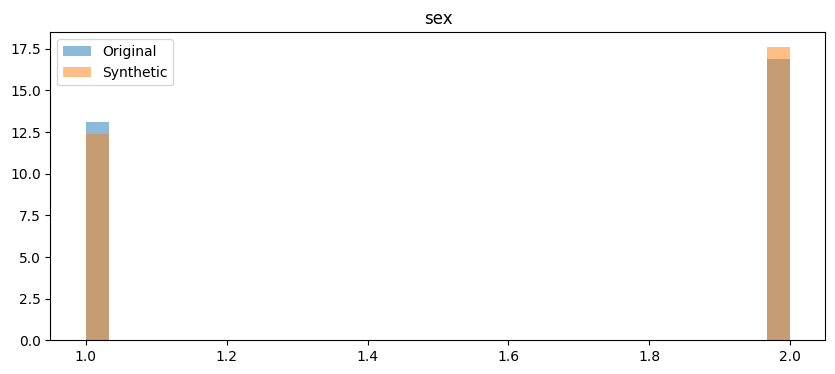

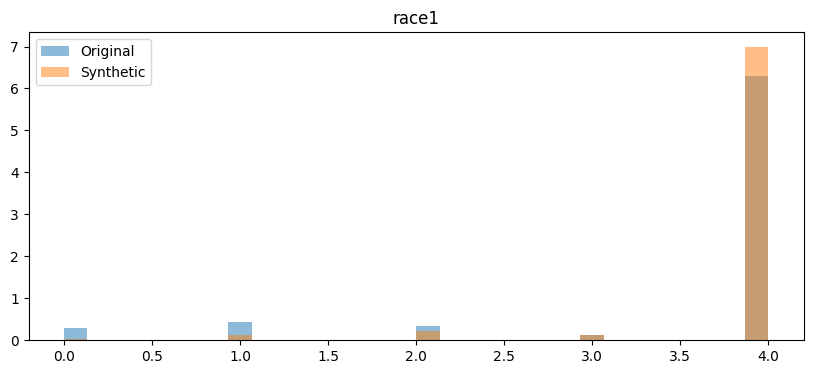

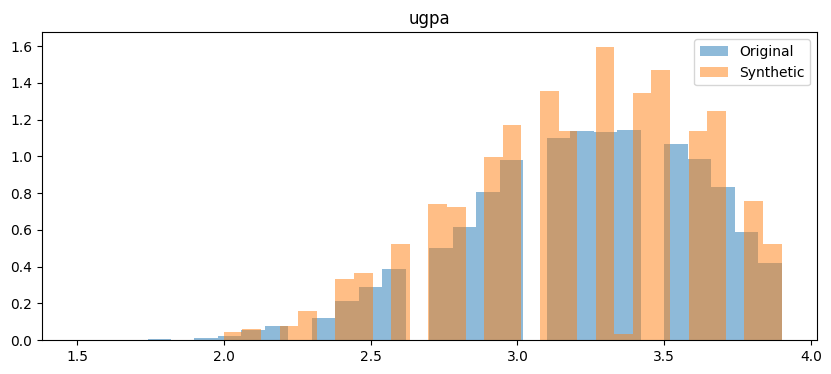

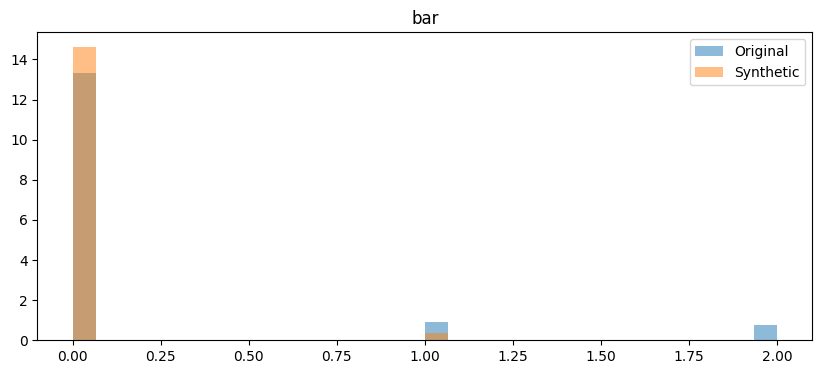

In [14]:
for column in real_data.columns:
    plt.figure(figsize=(10, 4))
    plt.hist(real_data[column], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(synthetic_data[column], bins=30, alpha=0.5, label='Synthetic', density=True)
    plt.title(f'{column}')
    plt.legend()
    plt.show()

#### 3.2 Correlation matrices

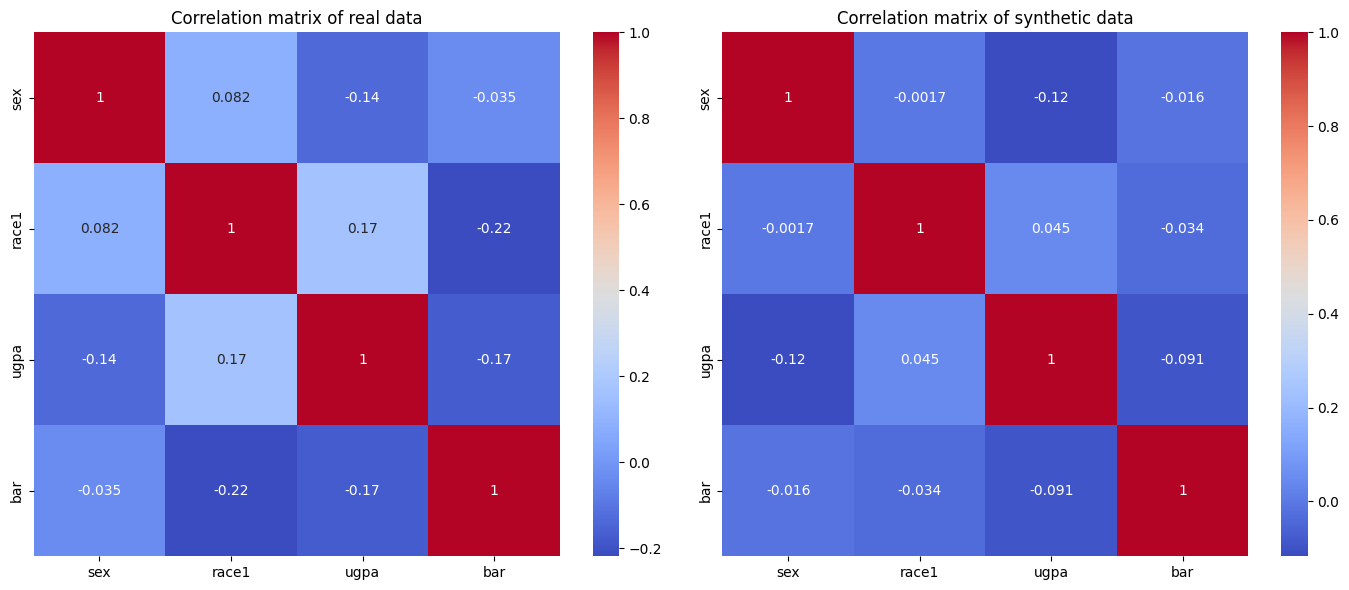

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot correlation matrix for real_data
sns.heatmap(real_data.corr(), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation matrix of real data')

# Plot correlation matrix for synthetic_data
sns.heatmap(synthetic_data.corr(), annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation matrix of synthetic data')

plt.tight_layout()
plt.show()

#### 3.3 Kolmogorov-Smirnov Test for numerical columns

**UI-text**

For numerical columns, The KSComplement returns 1-(KS statistics) where the Kolmogorov Smirnov (KS) statistic is the maximal difference between the CDF of the variable in the original and the synthetic data. A value close to 1 represents a better fit.

In [16]:
real_data.dtypes

sex      float64
race1      int64
ugpa     float64
bar        int64
dtype: object

In [17]:
for column in real_data.select_dtypes(include=['float64', 'int64']).columns:
    ks_stat, p_value = ks_2samp(real_data[column], synthetic_data[column])
    print(f'KS Test for {column}: KS Statistic = {ks_stat}, p-value = {p_value}')

KS Test for sex: KS Statistic = 0.023970676065991126, p-value = 0.6350619655422303
KS Test for race1: KS Statistic = 0.0929634307534146, p-value = 1.2829358632165526e-07
KS Test for ugpa: KS Statistic = 0.019731287022078603, p-value = 0.8446455093940756
KS Test for bar: KS Statistic = 0.08695966123268217, p-value = 1.0166063076332124e-06


#### 3.4 Chi-Square Test for categorical columns

For categorical columns, The TVComplement returns 1 - (TV Distance), where the Total Variation Distance measures the relative frequencies of the categories of a given variable in the original and the synthetic data. A value close to 1 represents a better fit

In [19]:
for column in real_data.select_dtypes(include=['category']).columns:
    contingency_table = pd.crosstab(real_data[column], synthetic_data[column])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-Square Test for {column}: Chi2 Statistic = {chi2_stat}, p-value = {p_value}')

In [21]:
# old
run_diagnostic(real_data, synthetic_data, target_column='gpa')

{'distribution_results': {'sex': {'ks_stat': 0.023970676065991126,
   'p_value': 0.6350619655422303},
  'race1': {'ks_stat': 0.0929634307534146, 'p_value': 1.2829358632165526e-07},
  'ugpa': {'ks_stat': 0.019731287022078603, 'p_value': 0.8446455093940756},
  'bar': {'ks_stat': 0.08695966123268217, 'p_value': 1.0166063076332124e-06}},
 'correlation_diff': 0.06383305963496694}